In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import sys
sys.path.append('../../Polished_code')

In [3]:
from tools import *

In [4]:
cirs = np.load('cirs_noised_ld.npy')
cirs_obs = np.load('cirs_observation_ld_exact.npy')
triplets = np.load('triplets_ld.npy')
anchor_idx = np.load('anchor_idx.npy')
pos_idx = np.load('pos_idx.npy')
neg_idx = np.load('neg_idx.npy')

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.pipeline import Pipeline
import lightgbm as lgb

In [6]:
location = 'london_square_20'
base = f'../../Simulation/dataset/data_with_building/{location}_cell.mat'
# base = f'../Simulation/dataset/data_with_building/{location}_cell.mat'
meta_data_ld, cir_profile_ld, dist_ld, TX_ld, RX_ld = read_mat(base, location)

In [7]:
max_len = 5
ext_ld = Extractor(cir_profile_ld)
X_ld = ext_ld.formatting_X(max_len=max_len)

../../Polished_code\tools.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mag = - math.floor(math.log(np.mean(self.delay_set), 10))
../../Polished_code\tools.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  cir_t.append(np.array(cir_shaped, dtype='float').flatten())


In [8]:
t_max = np.real(max(ext_ld.delay_set))
fc = 2e6 # sampling rate
W = 1e6
t = np.linspace(0,t_max, int(fc * t_max)+1)

In [64]:
def sinc_filter(cirs, t, snr=20):
    '''Adding sinc filtering to cirs'''
    T, S = cirs.shape
    cir_full_noise = []
    cir_pure = []
    # snr = 20

    x_pre = []
    for j in range(T):
        cir_t = [] # channel impulse response for a transmitter
        for i in range(S):
            status, _ = cirs[j, i].shape
            if status == 1:
                x_n = np.zeros_like(t)
                y = x_n
                # nan_idx.append([j, i]) # index of no-signal tx
            else:
                tau, amp = cirs[j, i].copy()
                tau_noise = np.random.normal(np.real(tau), .05 * np.real(tau))
                ans = np.repeat(t[:, None], len(tau), axis=1) - tau_noise
                y = np.sinc(W * ans) @ amp
                # c_tmp_noise = noise_gen(y, snr)
                n = len(y)
                noise = np.random.randn(n, 2).view(np.complex128)
                signal_power = np.sum(y * y) / n
                signal_db = 10 * np.log10(signal_power)
                noise_power = np.sum(noise * noise) / n
                noise_var = signal_power / (10 ** (snr/10))
                # noise_var = 10 ** ((signal_db - snr) / 10)
                # # print(noise_var)
                noise_gaussian = np.sqrt(noise_var / noise_power) * noise
                # noise_gaussian = np.random.normal(0, np.sqrt(noise_var), n).view(np.complex128)
            x_n = y + np.squeeze(noise_gaussian)
            cir_full_noise.append(x_n)
            cir_pure.append(cirs[j, i])

    return cir_full_noise, cir_pure


In [101]:
cirs_ld_sinc, cirs_pure = sinc_filter(cir_profile_ld, t, snr=10)

<StemContainer object of 3 artists>

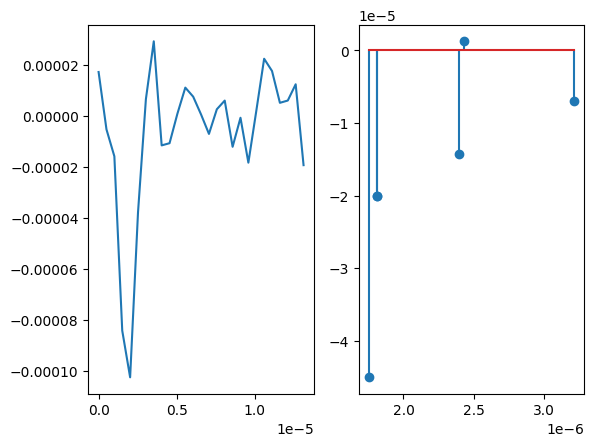

In [104]:
ind = np.random.randint(10000)
tau, amp = cirs_pure[ind]
fig, axs = plt.subplots(1, 2)
axs[0].plot(t, cirs_ld_sinc[ind])
axs[1].stem(tau, amp)

In [105]:
new_ld_sinc = np.reshape(cirs_ld_sinc, (400,-1))


In [106]:
ld_real, ld_imag = np.real(new_ld_sinc), np.imag(new_ld_sinc)
total = np.concatenate([ld_real, ld_imag], axis=1)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(total, TX_ld, train_size=.75)

In [126]:
rf_grid = {
    'rf__max_depth': [ 1000, 1500, 2000]
}

lgb_grid = {
    'lgb__estimator__n_estimators': [200, 500, 2000],
    'lgb__estimator__max_depth': [500, 1000, 2500]
}

xgb_grid = {
    'xgb__estimator__n_estimators': [200, 500, 2000],
    'xgb__estimator__max_depth': [500, 1000, 2500]
}

ada_grid = {
    'ada__estimator__n_estimators': [200, 500, 1000]
}

xgb_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), \
                    ('xgb', MultiOutputRegressor(xgb.XGBRegressor(eta=0.1, 
                                                    subsample=1, 
                                                    colsample_bytree=1, 
                                                    reg_lambda=0))
                                                    )]),
                xgb_grid)

lgb_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), \
                    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0)))]),
                lgb_grid)

rf_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), ('rf', RF())]), 
                rf_grid)

ada_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), \
                ('ada', MultiOutputRegressor(ABR(n_estimators=100)))]), 
                ada_grid)

In [127]:
pipes_ld = PipesFitting(total, TX_ld, RX_ld)
pipes_ld.add_pipes([lgb_pipe], ['LGBM'])
pipes_ld.fit()

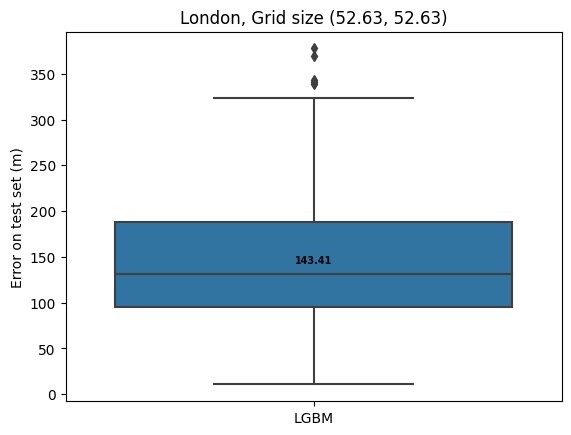

In [129]:
v_ld = VisualizeResult(pipes_ld, location='London')
v_ld.boxplot_pipes()

In [31]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, ada_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'ADA']

# pipes_ld = PipesFitting(np.real(cirs_obs), TX_ld, RX_ld)
pipes_ld = PipesFitting(total, TX_ld, RX_ld)
pipes_ld.add_pipes(pipes, model_ls)
pipes_ld.fit()

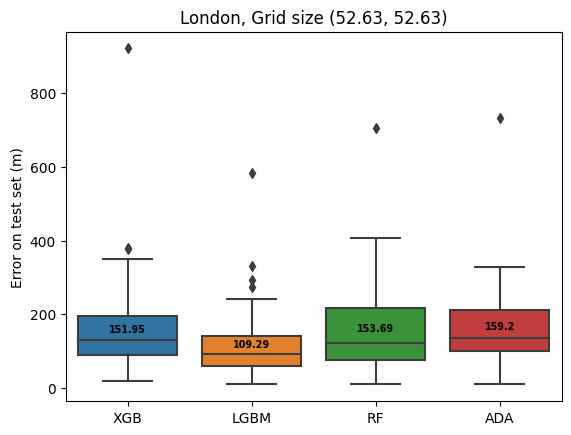

In [32]:
v_ld = VisualizeResult(pipes_ld, location='London')
v_ld.boxplot_pipes()

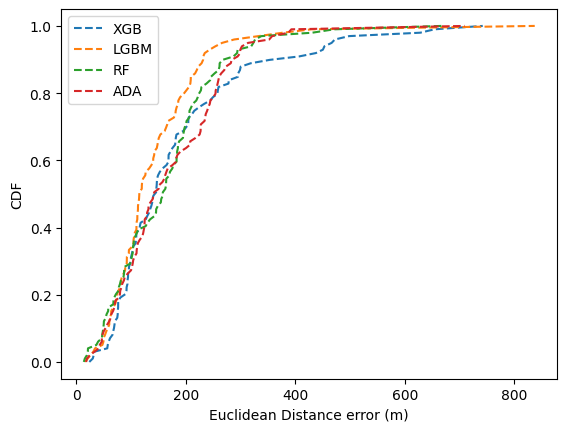

In [35]:
v_ld.cdf_plot()

## Prediction using RSSI

In [118]:
import scipy.io

In [119]:
rssi_dir = f'../../Simulation/dataset/rssi_london.mat'
rssi_ld = scipy.io.loadmat(rssi_dir)['rssi_london']

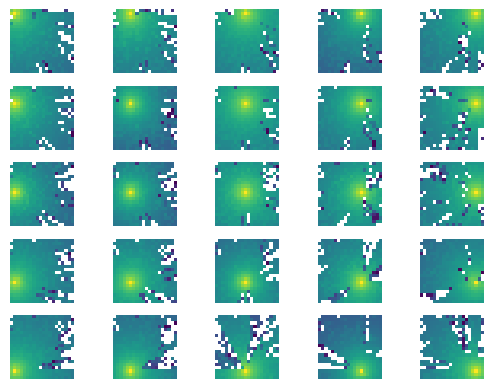

In [117]:
fig, axs = plt.subplots(5, 5)

for i in range(25):
    r, c = i // 5, i % 5
    tmp = np.reshape(rssi_ld[:, i], (20, 20))
    axs[r, c].imshow(tmp)
    axs[r, c].axis('off')

In [120]:
x_train, x_test, y_train, y_test = train_test_split(rssi_ld, TX_ld, train_size=.75)

In [122]:
rssi_ld = np.nan_to_num(rssi_ld, neginf=1)

In [123]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, ada_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'ADA']

pipes_ld = PipesFitting(rssi_ld, TX_ld, RX_ld)
pipes_ld.add_pipes(pipes, model_ls)
pipes_ld.fit()

In [130]:
pipes_rssi = [lgb_pipe]
model_rssi = ['LGBM']

pipes_ld_rssi = PipesFitting(rssi_ld, TX_ld, RX_ld)
pipes_ld_rssi.add_pipes(pipes_rssi, model_rssi)
pipes_ld_rssi.fit()

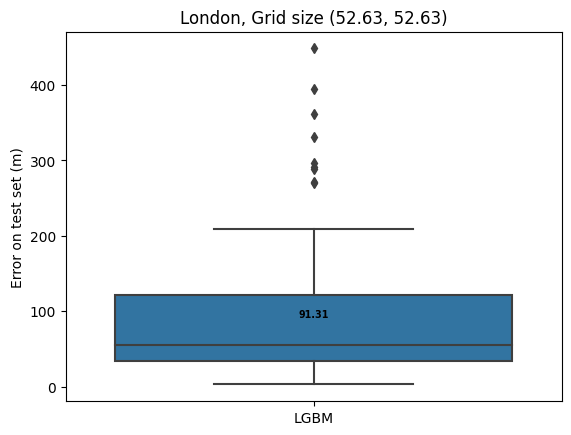

In [131]:
v_ld_rssi = VisualizeResult(pipes_ld_rssi, location='London')
v_ld_rssi.boxplot_pipes()

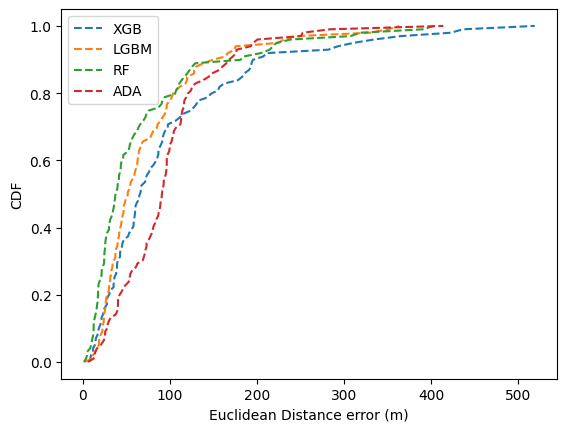

In [125]:
v_ld.cdf_plot()

Text(0.5, 0, 'distance error(m)')

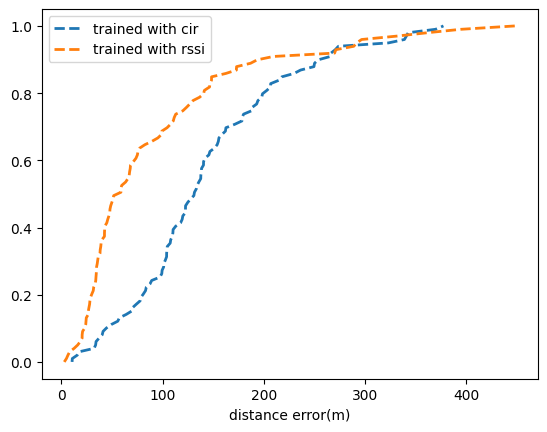

In [139]:
cdf_plot(pipes_ld.dist_all[0], label='trained with cir')
cdf_plot(pipes_ld_rssi.dist_all[0], label='trained with rssi')
plt.legend()
plt.xlabel('distance error(m)')

# 1NN

In [91]:
np.shape(total), np.shape(cirs_all)

((400, 1350), (400, 1350))

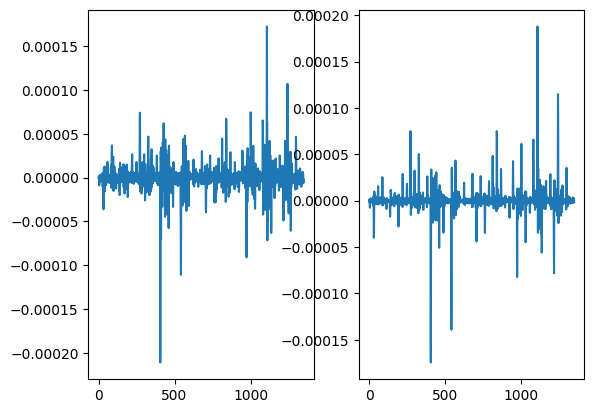

In [107]:
ind = np.random.randint(400)
tau, amp = cirs_pure[ind]
fig, axs = plt.subplots(1, 2)
axs[0].plot(total[ind])
axs[1].plot(cirs_all[ind])

In [108]:
cirs_all = np.concatenate([np.real(cirs_obs), np.imag(cirs_obs)], axis=1)

In [109]:
from sklearn.neighbors import NearestNeighbors

In [110]:
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(cirs_all)

In [111]:
cirs_all.shape, total[0].shape

((400, 1350), (1350,))

In [112]:
d, i = nn.kneighbors([total[1]])